<a href="https://colab.research.google.com/github/fjadidi2001/Cyber-Attack-Detection/blob/main/DL4cyber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Setup Environment and Unzip the Dataset

- Install necessary libraries.
- Mount Google Drive and unzip the dataset.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import zipfile

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Path to the ZIP file in Google Drive
zip_path = '/content/drive/MyDrive/network-intrusion-dataset.zip'
extract_dir = '/content/cic-ids2017/'

In [4]:
# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [5]:
# List extracted files
csv_files = [f for f in os.listdir(extract_dir) if f.endswith('.csv')]
print("Extracted CSV files:", csv_files)

Extracted CSV files: ['Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 'Friday-WorkingHours-Morning.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 'Monday-WorkingHours.pcap_ISCX.csv', 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', 'Wednesday-workingHours.pcap_ISCX.csv', 'Tuesday-WorkingHours.pcap_ISCX.csv']


In [6]:
# Visualization: Table of Extracted Files
files_df = pd.DataFrame(csv_files, columns=['CSV Files'])
print("\nTable of Extracted Files:")
print(files_df)


Table of Extracted Files:
                                           CSV Files
0   Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
1          Friday-WorkingHours-Morning.pcap_ISCX.csv
2  Friday-WorkingHours-Afternoon-PortScan.pcap_IS...
3  Thursday-WorkingHours-Afternoon-Infilteration....
4                  Monday-WorkingHours.pcap_ISCX.csv
5  Thursday-WorkingHours-Morning-WebAttacks.pcap_...
6               Wednesday-workingHours.pcap_ISCX.csv
7                 Tuesday-WorkingHours.pcap_ISCX.csv


# Step 2: Load and Preprocess Data

- Combine all CSV files into a single DataFrame.
- Handle missing values, encode categorical features, and normalize numerical features.
- Split into training, validation, and test sets.
- Visualize class distribution and feature correlations.

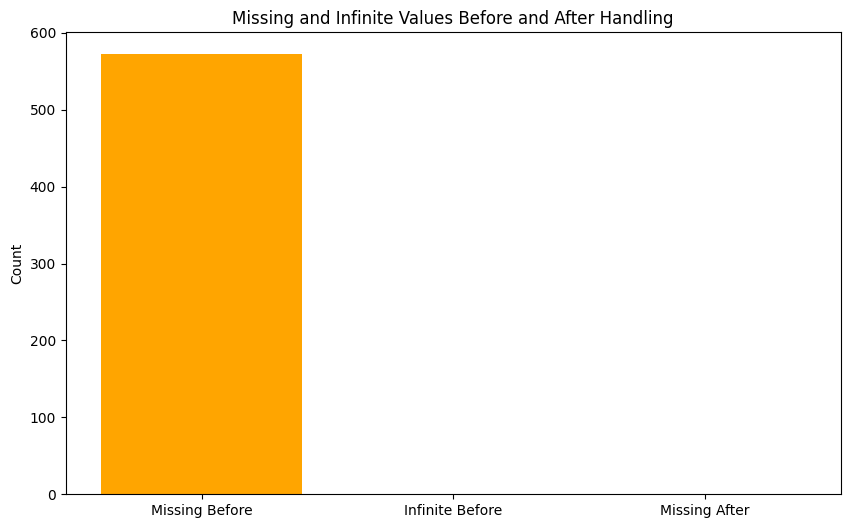


Dataset Summary Table:
   Feature Count  Total Rows  Classes  Training Samples  Validation Samples  \
0             78      283074       15            198151               42461   

   Test Samples  
0         42462  


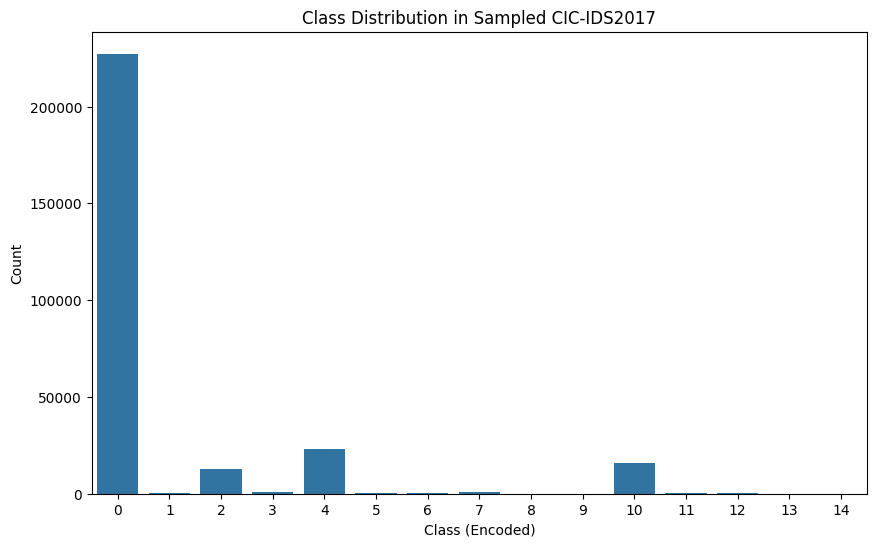

In [7]:
# Combine all CSV files into one DataFrame and sample 10% to reduce memory usage
dataframes = []
for csv_file in csv_files:
    df = pd.read_csv(os.path.join(extract_dir, csv_file))
    # Sample 10% of each file to manage RAM
    df_sampled = df.sample(frac=0.1, random_state=42)
    dataframes.append(df_sampled)

data = pd.concat(dataframes, ignore_index=True)

# Clean column names
data.columns = data.columns.str.strip()

# Replace infinity with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Handle missing values with median imputation for numerical columns
numerical_cols = data.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='median')
data_imputed = pd.DataFrame(imputer.fit_transform(data[numerical_cols]),
                            columns=numerical_cols)

# Handle categorical columns (e.g., 'Label') with mode imputation
categorical_cols = data.select_dtypes(exclude=[np.number]).columns
for col in categorical_cols:
    data_imputed[col] = data[col].fillna(data[col].mode()[0])

# Encode categorical features (Label)
le = LabelEncoder()
data_imputed['Label'] = le.fit_transform(data_imputed['Label'])

# Separate features and labels
X = data_imputed.drop('Label', axis=1)
y = data_imputed['Label']

# Normalize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Visualization 1: Missing and Infinite Values Bar Chart
missing_before = data.isnull().sum().sum()
inf_before = data.isin([np.inf, -np.inf]).sum().sum()
missing_after = data_imputed.isnull().sum().sum()
plt.figure(figsize=(10, 6))
plt.bar(['Missing Before', 'Infinite Before', 'Missing After'],
        [missing_before, inf_before, missing_after],
        color=['orange', 'red', 'green'])
plt.title('Missing and Infinite Values Before and After Handling')
plt.ylabel('Count')
plt.show()

# Visualization 2: Dataset Summary Table
summary_table = pd.DataFrame({
    'Feature Count': [X.shape[1]],
    'Total Rows': [X.shape[0]],
    'Classes': [len(np.unique(y))],
    'Training Samples': [X_train.shape[0]],
    'Validation Samples': [X_val.shape[0]],
    'Test Samples': [X_test.shape[0]]
})
print("\nDataset Summary Table:")
print(summary_table)

# Visualization 3: Class Distribution Bar Chart
plt.figure(figsize=(10, 6))
sns.countplot(x=y)
plt.title('Class Distribution in Sampled CIC-IDS2017')
plt.xlabel('Class (Encoded)')
plt.ylabel('Count')
plt.show()

# Step 3: Build and Train the Deep Learning Model

- Use a Multi-Layer Perceptron (MLP) for classification.
- Train with validation and plot training history.

Epoch 1/10
6193/6193 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.1435 - loss: nan - val_accuracy: 6.5943e-04 - val_loss: nan
Epoch 2/10
6193/6193 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 5.6419e-04 - loss: nan - val_accuracy: 6.5943e-04 - val_loss: nan
Epoch 3/10
6193/6193 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 4.4234e-04 - loss: nan - val_accuracy: 6.5943e-04 - val_loss: nan
Epoch 4/10
6193/6193 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 6.1981e-04 - loss: nan - val_accuracy: 6.5943e-04 - val_loss: nan
Epoch 5/10
6193/6193 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 4.9669e-04 - loss: nan - val_accuracy: 6.5943e-04 - val_loss: nan
Epoch 6/10
6193/6193 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 6.2021e-04 - loss: nan - val_accuracy: 6.5943e-04 - val_loss: nan
Epoch 7/10
6193/6193 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 5.7813e-04 - loss: nan - val_accuracy: 6.5943e-04 - val_loss: nan
Epoch 8/10
6193/6193 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 5.1894

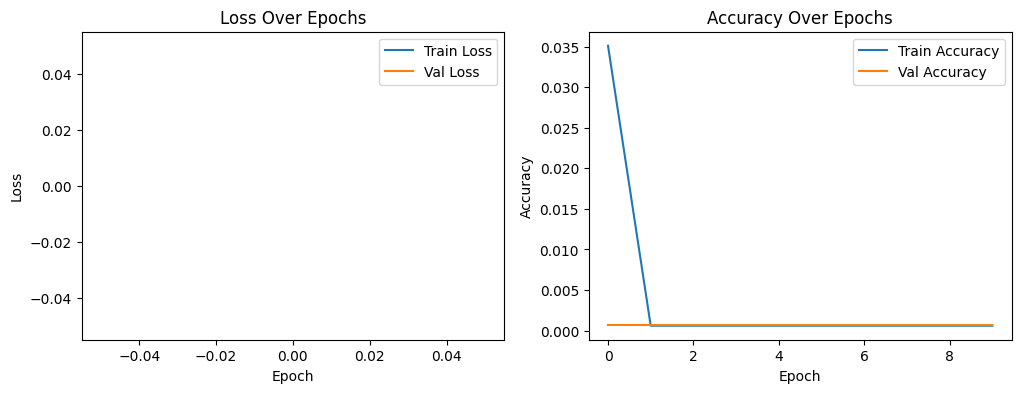


Model Architecture Table:
                                          Layer Info
0  Model: "sequential_1"\n┏━━━━━━━━━━━━━━━━━━━━━━...


In [9]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Visualization 1: Training History Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualization 2: Table of Model Architecture
model_summary = []
model.summary(print_fn=lambda x: model_summary.append(x))
print("\nModel Architecture Table:")
print(pd.DataFrame(model_summary, columns=['Layer Info']))

This model isn’t learning effectively. This could be due to issues like vanishing/exploding gradients, improper data preprocessing, or the model architecture not being suited to the task.

# Step 4: Evaluate and Visualize Results

- Compute metrics (accuracy, precision, recall, F1-score).
- Generate confusion matrix, ROC curve, pie chart of predictions, and scatter plots.